# [Exploration 07] 나랑 닮은 연예인을 찾아보자

## 프로젝트 설명 
- 이미지를 임베딩 벡터로 변환합니다.
    - 임베딩 벡터로 변환된 이미지는 컴퓨터가 이해할 수 있고, 쉽게 계산할 수 있습니
- 임베딩 벡터간의 거리를 측정합니다. 이 때, 거리를 측정하는 방법은 000을 사용합니다.
- 같은 인물이라면 거리가 0으로 나올테고, 가장 0에 가까운 거리에 있는 인물이 나와 가장 닮은 연예인입니다.
- 그럼 전 누구와 닮았을지 확인해보도록 하겠습니다.

## 01. 사진 모으기
- 내 사진과 비교할 연예인 얼굴이 담긴 사진으로 데이터셋을 만듭니다. 
    - 편리함을 위해 사진의 이름은 *연예인 이름*으로 설정합니다.
    - 얼굴 인식을 더 쉽게 하기 위해 독사진, 정면 사진으로만 총 383장을 구성하였습니다.(본인 사진 6장 포함)
    - 비교를 위한 내 사진은 2장 이상 데이터셋에 포함시킵니다.

In [48]:
import os

# 어떤 사진이 있는지 살펴봅니다.
dir_path = os.getenv('HOME')+'/aiffel/face_embedding/images'
file_list = os.listdir(dir_path)

print ("file_list: {}".format(file_list[:100]))
print ("사진 개수: {}".format(len(file_list)))

file_list: ['이엘리야.jpeg', '딕헌터.jpeg', '이민호.jpeg', '김태리리.jpeg', '승희.jpeg', '김남주.jpeg', '슈가.jpg', '존 파브르.jpeg', '트와이스사나.jpg', '김대명.jpeg', '온앤오프효진.jpg', '이말년.png', '앤드류 응.png', '신동엽.jpg', '제이크 질렌할.jpeg', '피어스 브로스넌.jpg', '이경규.jpeg', '김구라.jpg', '구혜선.jpeg', '박보영.jpeg', '손흥민.jpg', '레인보우재경.jpg', '리아.jpg', '최양락.jpg', '이나경.jpeg', '첸.jpeg', '트와이스정연.jpg', '아이린.jpeg', '김상호.png', '레드벨벳웬디.jpg', '김소현.jpeg', 'taylor swift.jpeg', '이대형.jpg', '크리스 햄스워스.jpg', '박보검.jpeg', '택연.jpg', '이광수.jpg', '차은우.jpeg', '씨잼.jpg', '티모시 달튼.jpeg', '마동석.jpeg', '김하영.jpeg', '장성호.jpeg', '조달환.png', '황정음.jpeg', '김종서.jpg', '케이.jpg', '한기범.jpg', '김C.jpeg', '함은정.jpeg', '태연.jpg', 'b1a4진영.jpeg', '솔라.jpg', 'minjung2.jpg', '미미.jpg', '옥냥이.jpeg', '한효주.jpeg', '제프리 힌턴.jpg', '태양.jpeg', '이제훈.jpeg', '정형돈.jpg', '류승범.jpg', '윤여정.jpeg', '최현석.jpg', '황병국.jpg', '유해진.jpg', '장원영.jpeg', '아이즈원민주.jpg', '김태희.jpeg', '윤종신.jpeg', '심수창.jpeg', '손예진.jpeg', '김유정.jpeg', '찬열.jpeg', '이종석.jpeg', '류현진.jpg', 'minjung5.jpg', '송중기.jpeg', '김래원.jpeg', 'biden.jpg', '이근대위.jpeg',

## 02. 얼굴 영역 자르기
- 사진에서 얼굴만 인식해줄 수 있는 얼굴인식 라이브러리 중 *dlib의 face_recognition*을 사용해 얼굴 영역만 잘라줍니다.
    - get_gropped_face() 함수를 통해 전체 이미지를 얼굴 영역으로 변환합니다.
- 추후 시각화를 위해 자른 이미지를 *PIL의 Image.fromarray*를 통해서 *PIL Image*로 변환한 뒤에 저장합니다.

**사진이 회전되는 경우 얼굴 영역을 인식하지 못하기 때문에, 회전되어있는 사진을 정방향으로 회전시키는 함수를 생성합니다.**

In [18]:
!pip install piexif

In [19]:
import os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from PIL import ExifTags
import piexif

not_orient=[]
not_exif=[]
def rotate(filename):

    img = Image.open(filename)

    if "exif" in img.info:
        exif_dict = piexif.load(img.info["exif"])
        #print(exif_dict)
        if piexif.ImageIFD.Orientation in exif_dict["0th"]:
            orientation = exif_dict["0th"].pop(piexif.ImageIFD.Orientation)
            exif_bytes = piexif.dump(exif_dict)
            #print('{} orientation value is {}'.format(filename,str(orientation)))
            
            if orientation == 2:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)

            elif orientation == 3:
                img = img.rotate(180)

            elif orientation == 4:
                img = img.rotate(180).transpose(Image.FLIP_LEFT_RIGHT)

            elif orientation == 5:
                img = img.rotate(-90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)

            elif orientation == 6:
                img = img.rotate(-90, expand=True)

            elif orientation == 7:
                img = img.rotate(90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)

            elif orientation == 8:
                img = img.rotate(90, expand=True)

            img.save(filename, exif=exif_bytes)
        else:
            #print('{} doesn\'t have exif orient info.'.format(filename))
            not_orient.append(filename)

    else:
        not_exif.append(filename)
        #print('{} doesn\'t have exif info.'.format(filename))

**trouble shooting**   
제 사진의 경우 전면 카메라로 촬영된 사진이 모두 회전되어있어 영역 추출이 안되있는 것을 발견했습니다.   
이를 해결하기 위해 사진의 exif를 이용해 회전된 사진을 다시 회전시키는 함수로 처리했습니다.

In [22]:
file_list = ['minjung.jpg', 'minjung0.jpg', 'minjung1.jpg', 'minjung3.jpg', 'minjung4.jpg', 'minjung5.jpg']
for file in file_list:
    img_path = os.path.join(dir_path, file)
    rotate(img_path)

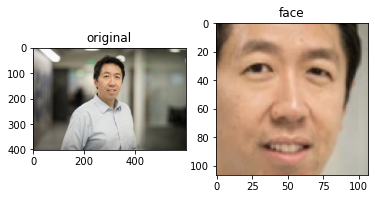

In [49]:
import face_recognition
import matplotlib.pyplot as plt

# %matplotlib inline

def get_gropped_face(image_file):
    image = face_recognition.load_image_file(image_file)    # image path에 있는 image를 불러옴
    face_locations = face_recognition.face_locations(image) # face_recognition으로 얼굴 영역 좌표를 가져옴
    if len(face_locations)==0:
        return []
    
    a, b, c, d = face_locations[0]                          # 얼굴 영역 좌표 언패킹
    cropped_face = image[a:c,d:b,:]                         # 좌표에 해당하는 부분만 자르기
    
    return cropped_face                                     # 사진에서 얼굴만 자름

# 딥러닝을 공부하면 누구나 알게되는 앤드류 응의 사진으로 테스트를 해봅시다 !
image_file = os.path.join(dir_path, '앤드류 응.png')
image = face_recognition.load_image_file(image_file)
face = get_gropped_face(image_file)  

# 원본 사진과 get_gropped_face 함수로 자른 얼굴 사진을 비교해봅시다 !
f = plt.figure()
x0=f.add_subplot(1,2, 1)
x0.set_title('original')
plt.imshow(image)
x1=f.add_subplot(1,2, 2)
x1.set_title('face')
plt.imshow(face)
plt.show(block=True)

**matplotlib으로 확인해보니 사진 중 정확하게 이목구비가 있는 얼굴 영역만 잘라낸 것을 확인했습니다.**

## 03. 얼굴 영역의 임베딩 추출하기
- 얼굴 영역만 자른 사진에 *face_recognition* 을 사용해서 이미지를 불러오고 임베딩을 추출합니다. 
- 추출한 임베딩 벡터는 다른 사진들과 구분할 수 있게 따로 저장합니다. 
    - def get_face_embedding(face) : 얼굴영역으로부터 얼굴 임베딩 벡터를 구하는 함수
    - def get_face_embedding_dict(dir_path) : 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수

In [50]:
import face_recognition
import matplotlib.pyplot as plt

# %matplotlib inline

def get_face_embedding(face):
    return face_recognition.face_encodings(face)     # face_recognition.face_encodings를 이용해 임베딩 벡터를 구함

# 마찬가지로 앤드류 응 얼굴의 임베딩 벡터를 구해봅시다 !
embedding = get_face_embedding(face)                 
embedding

[array([-0.09306732,  0.06016326,  0.04344617,  0.04054739, -0.13697796,
        -0.01066917, -0.02318625, -0.10237946,  0.03511224, -0.08482285,
         0.16976541, -0.14375246, -0.21076521, -0.06730828, -0.05052896,
         0.19568747, -0.20832452, -0.08328547, -0.09301031, -0.00702115,
         0.11144199, -0.02229559, -0.03422875,  0.02957623, -0.05765034,
        -0.36928117, -0.07181814, -0.07859614,  0.06145369, -0.08208504,
        -0.07258441,  0.05332732, -0.19181742, -0.11048973, -0.0015724 ,
         0.03044825, -0.02528475, -0.05756157,  0.17449252, -0.00098519,
        -0.20021908,  0.05369996,  0.04745963,  0.24573736,  0.21497411,
         0.07885256,  0.00605723, -0.01781133,  0.09799352, -0.28318951,
        -0.04646241,  0.133764  ,  0.06702425,  0.13560958, -0.02117542,
        -0.14086518,  0.03193157,  0.09185884, -0.13098696,  0.05820529,
         0.07757542, -0.1331652 ,  0.01397562, -0.04610188,  0.2607477 ,
         0.05272662, -0.10528772, -0.15161102,  0.0

**얼굴 임베딩 벡터는 128차원으로 잘 추출된 것을 확인했습니다.**    



- 이제, 데이터 셋 전체의 임베딩 벡터를 불러오고, {파일명:임베딩} 으로 구성된 임베딩 사전을 만들겠습니다.

In [126]:
def get_face_embedding_dict(dir_path, file_list=file_list):
    file_list = os.listdir(dir_path)
    embedding_dict = {}                      # {파일명:임베딩}으로 구성할 딕셔너리를 선언
    for file in file_list:
        img_path = os.path.join(dir_path, file)
        face = get_gropped_face(img_path)    # 사진에서 얼굴 영역만 자르는 함수
        if len(face)==0:
            continue
        embedding = get_face_embedding(face) # 얼굴 영역에서 임베딩 벡터를 구함
        if len(embedding) > 0:  # 얼굴영역 face가 제대로 detect되지 않아  len(embedding)==0인 경우를 제외합니다.
            embedding_dict[os.path.splitext(file)[0]] = embedding[0] # 확장자 제거

    return embedding_dict

embedding_dict = get_face_embedding_dict(dir_path)

*get_face_embedding_dict*이 잘 작동하는 지 제 사진으로 확인해보겠습니다.

In [35]:
print(embedding_dict['minjung'])

[-0.12500787  0.09437     0.00809179 -0.14289898 -0.18382196 -0.00118586
 -0.06177557 -0.10006017  0.1364087  -0.17508413  0.17096876 -0.09524044
 -0.27202943 -0.01387967 -0.09325377  0.23789501 -0.19282281 -0.15720032
 -0.07470156  0.0303565   0.0896666   0.04276347 -0.02229673  0.03967834
 -0.040007   -0.34731603 -0.05842449 -0.0670884  -0.05648824 -0.04813473
 -0.00109657  0.06153556 -0.16483249 -0.01653449 -0.01637842  0.11194497
 -0.02116055 -0.12928331  0.09630154 -0.00269598 -0.29135078  0.00437278
  0.04402018  0.19636115  0.14919865  0.00108166  0.01696388 -0.13776593
  0.13411558 -0.21252972 -0.0388239   0.09201854  0.01995125  0.03626014
  0.03606706 -0.16439891  0.09563997  0.11700669 -0.13732918 -0.02902269
  0.10626764 -0.06536132  0.04824962 -0.10725037  0.27769434  0.09062345
 -0.11184963 -0.17434229  0.15042567 -0.11052983 -0.09450755  0.03881767
 -0.15865982 -0.15013225 -0.25421965 -0.00462577  0.36801821  0.12281071
 -0.1318298   0.03984847 -0.03985976  0.02475111  0

## 04. 사진 간 임베딩 벡터 거리 비교하기
- *get_face_embedding_dict*함수로 구한 임베딩 사전을 이용해 사진 간 임베딩 벡터 거리를 구하겠습니다.
    - 계산이 쉽도록 리스트를 넘파이 배열로 변환합니다.
    - 각 벡터간의 거리를 *numpy.linalg.norm*를 활용하여 **L2 Norm Distance**로 계산합니다.
    
**먼저, 제 얼굴 사진 두 장의 거리를 계산해보겠습니다.**

In [51]:
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

print(get_distance('minjung', 'minjung0'))
print(get_distance('minjung', 'minjung1'))
print(get_distance('minjung', 'minjung2'))
print(get_distance('minjung', 'minjung3'))
print(get_distance('minjung', 'minjung4'))
print(get_distance('minjung', 'minjung5'))

0.28130811981689285
0.34539603705648886
0.4095954786469252
0.31893867211647553
0.39139338651040867
0.34332580910191685


**특정 사진과 모든 사진의 거리를 계산하는 함수 *get_sort_key_func*를 생성하겠습니다.**

In [52]:
# name1과 name2의 거리를 비교하는 함수를 생성하되, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 합니다.
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

sort_key_func = get_sort_key_func('minjung')   
# sort_key_func('파일명') 이라고 호출하면 '파일명'과 'minjung'사진의 임베딩 거리를 계산하게 됩니다.

**입력받은 특정 이름에 대해 닮은 꼴을 출력할 수 있는 함수를 생성합니다.**

In [152]:
best5=[]      # 닮은 꼴 Best 5를 저장한다. 
def get_nearest_face(name, top=6):           # top으로 내 얼굴 사진을 제외한다.  
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    for i in range(top+1, top+6):
        if i == 0:
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i-6, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
            best5.append(sorted_faces[i][0])

In [153]:
get_nearest_face('minjung')

순위 1 : 이름(김현수), 거리(0.4182925890699355)
순위 2 : 이름(서현진), 거리(0.4229357056416213)
순위 3 : 이름(오연서), 거리(0.4231530157436279)
순위 4 : 이름(강미나), 거리(0.42749155824464435)
순위 5 : 이름(러블리즈지수), 거리(0.4378454344818715)


## 05. 다양한 재미있는 시각화 시도해 보기
- 먼저 닮은 꼴 Best 5와 제 사진을 출력해보겠습니다.

In [154]:
best5.append('minjung')
best5

['김현수', '서현진', '오연서', '강미나', '러블리즈지수', 'minjung']

In [160]:
best5_list=[]
for file in file_list:
    for i in best5:
        if i in file:
            best5_list.append(file)
best5_list

['minjung2.jpg',
 'minjung5.jpg',
 '오연서서.jpg',
 '김현수.jpg',
 'minjung4.jpg',
 'minjung.jpg',
 'minjung1.jpg',
 '러블리즈지수.jpg',
 'minjung0.jpg',
 '서현진.jpg',
 '강미나.jpg',
 '오연서.jpg',
 'minjung3.jpg']

이름이 중복되는 사진이 있는 것을 알 수 있습니다.   
먼저 해당 사진들의 확장자를 일치시키겠습니다.

In [158]:
for i in best5_list:
    file_list = os.listdir(dir_path)
    img_path = os.path.join(dir_path, i)
    new_best5_list = os.path.splitext(img_path)[0] + '.jpg'
    os.rename(img_path, new_best5_list)

In [161]:
best5_list

['minjung2.jpg',
 'minjung5.jpg',
 '오연서서.jpg',
 '김현수.jpg',
 'minjung4.jpg',
 'minjung.jpg',
 'minjung1.jpg',
 '러블리즈지수.jpg',
 'minjung0.jpg',
 '서현진.jpg',
 '강미나.jpg',
 '오연서.jpg',
 'minjung3.jpg']

**확장자를 일치시켰으니, 해당 사진들 중 닮은 사진을 뽑겠습니다.**
- 먼저, 해당 사진들의 임베딩만 구합니다.

In [128]:
embedding_dict = get_face_embedding_dict(dir_path, file_list=best5_list)

In [175]:
sort_key_func = get_sort_key_func('minjung')
sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
for i in range(7, 12):
        if i == 0:
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i-6, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
            best5.append(sorted_faces[i][0])

순위 1 : 이름(김현수), 거리(0.4182925890699355)
순위 2 : 이름(서현진), 거리(0.4229357056416213)
순위 3 : 이름(오연서), 거리(0.4231530157436279)
순위 4 : 이름(강미나), 거리(0.42749155824464435)
순위 5 : 이름(러블리즈지수), 거리(0.4378454344818715)


In [162]:
face_list =[]
for i, file in enumerate(best5):
    image_file = os.path.join(dir_path, f'{file}.jpg')
    face = get_gropped_face(image_file)  
    face_list.append(face)
    
image_file = os.path.join(dir_path, 'minjung.jpg')
image = face_recognition.load_image_file(image_file)
me = get_gropped_face(image_file) 

image_file = os.path.join(dir_path, '김현수.jpg')
image = face_recognition.load_image_file(image_file)
rank1 = get_gropped_face(image_file) 

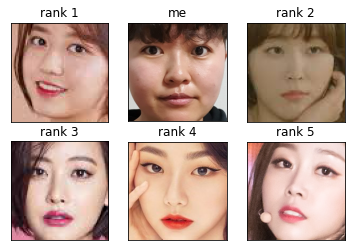

In [202]:
# 닮은 꼴 Best5 얼굴만 자르기
f = plt.figure()
x0=f.add_subplot(2, 3, 1)
x0.set_title('rank 1')
x0.axes.get_xaxis().set_visible(False)
x0.axes.get_yaxis().set_visible(False)
plt.imshow(face_list[0])

x1=f.add_subplot(2, 3, 2)
x1.set_title('me')
x1.axes.get_xaxis().set_visible(False)
x1.axes.get_yaxis().set_visible(False)
plt.imshow(me)

x2=f.add_subplot(2, 3, 3)
x2.set_title('rank 2')
x2.axes.get_xaxis().set_visible(False)
x2.axes.get_yaxis().set_visible(False)
plt.imshow(face_list[1])

x3=f.add_subplot(2, 3, 4)
x3.set_title('rank 3')
x3.axes.get_xaxis().set_visible(False)
x3.axes.get_yaxis().set_visible(False)
plt.imshow(face_list[2])

x4=f.add_subplot(2, 3, 5)
x4.set_title('rank 4')
x4.axes.get_xaxis().set_visible(False)
x4.axes.get_yaxis().set_visible(False)
plt.imshow(face_list[3])

x5=f.add_subplot(2, 3, 6)
x5.set_title('rank 5')
plt.imshow(face_list[4])
x5.axes.get_xaxis().set_visible(False)
x5.axes.get_yaxis().set_visible(False)

# 정리     
---        
1. 사진 모으기         
    - 얼굴 정면 사진을 모은다.
2. 얼굴 영역 자르기         
    - dlib의 face_recognition을 사용해 얼굴 영역 좌표로 사진을 자른다.            
3. 얼굴 영역의 임베딩 추출하기    
    - face_recognition을 사용해서 얼굴 영역 이미지에서 임베딩 벡터를 추출한다.
4. 사진 간 임베딩 벡터 거리 비교하기       
    - 각 사진의 벡터 거리를 L2 Norm Distance로 계산한다.
    - 가장 닮은 사진을 찾는다.
5. 다양한 재미있는 시각화 시도해 보기         
    - 사진을 출력해본다.


# 루브릭 평가
---
1. **얼굴임베딩 벡터를 활용해 가장 닮은 연예인 Best 5를 구할 수 있다.**   
    - 가장 닮은 연예인 Best 5의 순위, 이름, 거리를 나타냈습니다.


2. **충분한 수의 이미지에 대한 시도를 통해 매우 닮은꼴의 연예인을 찾아냈다.**  
    - 거리가 0.5이내인 연예인을 찾았습니다.
    
     
3. **다양하고 재미있는 결과 시각화를 시도하였다.**  
    - matplotlib 등 다양한 시각화 도구를 하나 이상 이용해 재미있는 결과 시각화를 구현하였다.

    
# 회고
---
## 더 공부하고 싶은 부분
- 코딩 : 마지막에 시각화하는 부분에서 더 효율적인 코드를 짤 수 있을 것 같은데 하지 못했다.
- 시각화 : 플롯을 구성하고, 시각화하는 부분이 너무 부족하다.

## 느낀 점
데이터 셋의 구성에 따라 결과가 많이 다를 것이라고 생각이 든다. 데이터셋의 양이 너무 적었다. 크롤링으로 10000장 정도 수집한 후의 결과가 궁금하다. 하지만 크롤링 후, 전처리하는 과정이 시간이 너무 많이 걸릴 것이라고 판단돼 이번엔 하지 못한 점이 아쉽다. 또한, 닮은 사진끼리 겹쳐보고 싶어서 여러 코드로 시도해봤지만, 실패한 점이 아쉽다... 여러모로 아쉬움이 많이 남는 프로젝트였다.